In [1]:
# Import python modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import sys

import itable

from linkage_tools import *
from Probabilistic import *
from Perceptron import *

'''
from NeuralNetwork import *
'''

l = Linker()

#import warnings
#warnings.filterwarnings('error')

verbose = True

### Define linking variables

In [2]:
# Define tables
tableA = '''patient_discharges JOIN newborns
ON patient_discharges.id = newborns.patient_discharge_id
LEFT OUTER JOIN patient_payers AS newborn_payers
ON newborn_payers.patient_discharge_id = patient_discharges.id'''

tableB = '''births JOIN deliveries 
ON births.delivery_id = deliveries.id
JOIN patient_discharges AS delivery_discharges
ON deliveries.patient_discharge_id = delivery_discharges.id
LEFT OUTER JOIN patient_payers AS delivery_payers
ON delivery_payers.patient_discharge_id = delivery_discharges.id'''

# Define fields to compare tables by
tableA_fields = ['patient_discharges.sex_id','newborns.id','newborns.cesarean_section', 
            'patient_discharges.zip_code','patient_discharges.race_id','patient_discharges.ethnicity_id', 
                'newborn_payers.payer_type_of_coverage_id','patient_discharges.principal_language_spoken', 
                 'patient_discharges.discharged_on','newborn_payers.payer_category_id',
                 'newborn_payers.plan_code_number','newborns.birth_weight_group_id',
                 'newborns.gestational_age_group_id','newborns.plurality_group_id']

tableB_fields = ['births.sex_id','births.newborn_id','births.delivery_route_id', 
            'births.mothers_residence_zip_code','delivery_discharges.race_id','delivery_discharges.ethnicity_id', 
                'delivery_payers.payer_type_of_coverage_id','delivery_discharges.principal_language_spoken', 
                 'delivery_discharges.discharged_on','delivery_payers.payer_category_id',
                 'delivery_payers.plan_code_number','births.birth_weight',
                 'births.gestational_age_ob_estimate','births.plurality'] 

feature_vals = ['sex_id','c_section','zip_code','race','ethnicity','payer_type_of_coverage_id',
                'language_spoken','discharge','payer_category_id','plan_code_number','weight_group_id',
                'gest_age_group_id','plurality','weight_plus','weight_minus']

# Define bins to use for certain fields
age_bins = np.concatenate(([1,24], np.arange(25, 36, 2),[99]), axis=0)
bw_bins = np.concatenate(([1], np.arange(500, 2001, 250),[2500,9999]), axis=0)
    
# Define conditions (expressions) on which to compare fields
conditions = [  "cross_table['sex_id_x']==cross_table['sex_id_y']",
                "cross_table['cesarean_section']==cross_table['delivery_route_id']",
                "cross_table['zip_code']==cross_table['mothers_residence_zip_code']",
                "cross_table['race_id_x']==cross_table['race_id_y']",
                "cross_table['ethnicity_id_x']==cross_table['ethnicity_id_y']",
                "cross_table['payer_type_of_coverage_id_x']==cross_table['payer_type_of_coverage_id_y']",
                "cross_table['principal_language_spoken_x']==cross_table['principal_language_spoken_y']",
                "cross_table['discharged_on_x']==cross_table['discharged_on_y']",
                "cross_table['payer_category_id_x']==cross_table['payer_category_id_y']",
                "cross_table['plan_code_number_x']==cross_table['plan_code_number_y']",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)",
                "cross_table['gestational_age_group_id']==np.digitize(list(cross_table['gestational_age_ob_estimate']/7),age_bins)+1",
                "cross_table['plurality_group_id']==cross_table['plurality']",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)+1",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)-1"   ] 

simple_features = feature_vals[0:13]
complex_features = feature_vals[13:]

### Blocking

In [29]:
"""
# Find relative frequencies of values in each field
# - save each as dictionary (1 dict per field per table)
rel_freq_tA = {}
for i in tableA_fields:
    stmt = '''SELECT {0} value, COUNT(*) count
    FROM {1}
    GROUP BY {0};'''.format(i,tableA)
    field_dict = exec_statement(stmt,'dict')
    rel_freq_tA[i] = dict(zip(field_dict['value'],field_dict['count']))
    
rel_freq_tB = {}
for i in tableB_fields:
    stmt = '''SELECT {0} value, COUNT(*) count
    FROM {1}
    GROUP BY {0};'''.format(i,tableB)
    field_dict = exec_statement(stmt,'dict')
    rel_freq_tB[i] = dict(zip(field_dict['value'],field_dict['count']))
"""

# BROKEN
def rel_freq(table_fields,table):
    # Find relative frequencies of values in each field
    # - save each as dictionary (1 dict per field per table)
    freq_out = {}
    for i in table_fields:
        stmt = '''SELECT {0} value, COUNT(*) count
        FROM {1}
        GROUP BY {0};'''.format(i,table)
        field_dict = l.exec_sql(stmt).to_dict()
        print field_dict
        freq_out[i] = dict(zip(field_dict['value'],field_dict['count']))
    
rel_freq_tA = rel_freq(tableA_fields,tableA)
rel_freq_tB = rel_freq(tableB_fields,tableB)

{u'count': {0: 13794, 1: 23248, 2: 1}, u'value': {0: 1, 1: 2, 2: 3}}
{u'count': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 

{u'count': {0: 7506, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 135: 1, 136: 1,

{u'count': {0: 20388, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 2, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 3, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 2, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 2, 85: 1, 86: 2, 87: 1, 88: 1, 89: 1, 90: 3, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 2, 107: 1, 108: 1, 109: 1, 110: 1, 111: 2, 112: 2, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 2, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 3, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 135: 1, 136: 1

In [33]:
# Find all possible values for 1st blocking field ('hospital_id')
stmt = '''
SELECT DISTINCT patient_discharges.hospital_id
FROM patient_discharges 
UNION
SELECT DISTINCT births.hospital_id
FROM births;'''
block_list1 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

block_list1 = [block_list1[0]]

# Find all possible values for 2nd blocking field ('date_of_delivery')
stmt = '''
SELECT DISTINCT births.date_of_delivery
FROM births;'''
block_list2 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

block_list2 = block_list2[500:575]

block_prod = [(str(x),str(y)) for x in block_list1 for y in block_list2]

# Assign strings to select each block
blocking_stmt1 = '''
        SELECT patient_discharges.id AS pdd_id, newborns.id AS newb_id,%s 
        FROM %s
        WHERE patient_discharges.hospital_id = %r
        AND patient_discharges.date_of_birth = %r;
        '''
blocking_stmt2 = '''
        SELECT births.id AS bc_id,%s
        FROM %s
        WHERE births.hospital_id = %r
        AND births.date_of_delivery = %r;
        '''

### Create learners and iterate over each block
- Create [probabilistic] and [perceptron] learners (train each on selected subset of features ['simple' vs. 'complex'])
- Loop over each block and convert to pandas dataframe
- Cross join the features-of-interest from both blocks
- Apply conditional statements to each column of dataframe
- Return match score from each learner
- Maximize pairing with Kuhn-Munkres (i.e. Hungarian) Algorithm [more info]
- Compare guesses to truth, update weights/probabilities

[more info]: https://pypi.python.org/pypi/munkres/
[perceptron]: http://glowingpython.blogspot.com/2011/10/perceptron.html
[probabilistic]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5005943/

In [4]:
learning_rate = 0.01 # small, constant learning rate for perceptron

# Create instances of learners
pr_simple = Probabilistic(len(simple_features)) # probabilistic linkage (simple features only)
pr_complex = Probabilistic(len(conditions)) # probabilistic linkage (all features)

pt_simple = Perceptron(len(simple_features),learning_rate) # single-layer perceptron (simple features only)
pt_complex = Perceptron(len(conditions),learning_rate) # single-layer perceptron (all features)

# n = l.neuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate) # multi-layer neural network

# tss_iter_list = []
iter_qual_list = []
block_duration = [] # for timer
iter_duration = []
#cur_iter_qual = 0.0 # for breaking link-iteration loop
link_iter = 0
verb_str = '\r Iter. #{}, blockA: {} records, blockB: {} records  ' # verbose output

while True:

    big_bool = pd.DataFrame(columns=feature_vals)

    #tss = 0.0 # total sum-squared error
    
    iter_start = time.time() # Measure iteration duration

    for block1, block2 in block_prod:
        
        block_start = time.time() # Measure block duration

        # Create 'blockA'
        blockA = l.exec_sql(blocking_stmt1 % (",".join(tableA_fields),tableA,block1,block2))

        # Create 'blockB'
        blockB = l.exec_sql(blocking_stmt2 % (",".join(tableB_fields),tableB,block1,block2))
        
        if verbose:
            # Print on each iteration
            sys.stdout.write(verb_str.format(link_iter+1, len(blockA), len(blockB)))
        
        # Check that neither block is empty - If empty, skip to next record-pair iteration in loop
        if (len(blockA)==0) or (len(blockB)==0):
            continue

        # Cross-join both blocks
        cross_table = l.df_crossjoin(blockA, blockB)

        # Count field matches and dump each into new column of dataframe
        bool_table = pd.DataFrame.from_items(zip(feature_vals,[eval(x).values for x in conditions]))

        # Add record-id columns to boolean table
        bool_table['newb_id'] = cross_table['newb_id'].values # Actual newborn id
        bool_table['bc_id'] = cross_table['bc_id'].values  # Actual bc id
        record_id = bool_table[['newb_id','bc_id']]

        # Compare with previously-linked newborn id
        bool_table['real_match'] = (cross_table['newborn_id']==cross_table['newb_id']).values 
        bool_table['match'] = False # Create new column for later
        bool_table['match_simple'] = False # Create new column for later
        bool_table['match_perc'] = False # Create new column for later
        bool_table['match_perc_simple'] = False # Create new column for later

        # Get guesses from learners
        links_ind,link_score = pr_simple.query(bool_table[simple_features],record_id)
        bool_table['lscore_simple'] = link_score
        bool_table.loc[links_ind,'match_simple'] = True # Label nominees as such  
        
        links_ind,link_score = pr_complex.query(bool_table[feature_vals],record_id)
        bool_table['lscore'] = link_score
        bool_table.loc[links_ind,'match'] = True     
  
        links_ind,link_score = pt_simple.query(bool_table[simple_features],record_id)
        bool_table['lscore_perc_simple'] = link_score
        bool_table.loc[links_ind==1,'match_perc_simple'] = True
        
        links_ind,link_score = pt_complex.query(bool_table[feature_vals],record_id)
        bool_table['lscore_perc'] = link_score
        bool_table.loc[links_ind==1,'match_perc'] = True       
        
        # Train perceptron learners on each 
        pt_complex.train(bool_table[feature_vals],bool_table['real_match'],record_id)
        pt_simple.train(bool_table[simple_features],bool_table['real_match'],record_id)
        
        # Aggregate field-match tables (Booleans) within loop
        big_bool = pd.concat([big_bool,bool_table])

        # Time duration of each block
        block_duration.append(time.time()-block_start)

    # Train probabilistic learners
    pr_complex.train(big_bool[feature_vals],big_bool['match'])
    pr_simple.train(big_bool[simple_features],big_bool['match_simple'])
    
    ## SUM-OF-SQUARES?
    
    # Measure current precision & recall for all learners
    # Get range of linkage scores (0 through 100 percentiles) i.e. decision threshold (theta)
    get_thetas = lambda x: np.percentile(big_bool[x].loc[big_bool['real_match']],range(0,100,10))
    
    theta = get_thetas('lscore')
    pr_complex.prec_recall(big_bool['lscore'],theta,big_bool['real_match'])
    
    theta = get_thetas('lscore_simple')
    pr_simple.prec_recall(big_bool['lscore_simple'],theta,big_bool['real_match'])
    
    theta = get_thetas('lscore_perc')
    pt_complex.prec_recall(big_bool['lscore_perc'],theta,big_bool['real_match'])
    
    theta = get_thetas('lscore_perc_simple')
    pt_simple.prec_recall(big_bool['lscore_perc_simple'],theta,big_bool['real_match'])
    
    # Compare current iteration 'quality' with previous iterations
    cur_iter_list = [o.iter_qual_list[-1] for o in [pr_complex,pr_simple,pt_complex,pt_simple]]
    prev_iter_list = [o.iter_qual_list[-2] for o in [pr_complex,pr_simple,pt_complex,pt_simple]]

    # Break from outer loop
    if all(np.subtract(cur_iter_list,prev_iter_list)<.1): # If not improving
        print str.format("\n'Quality' achieved! @ {}",cur_iter_list)
        break

    if verbose:
        #print '\n',pd.DataFrame([m_probs, u_probs, weights],index=['m_probs', 'u_probs', 'weights'])
        print str.format('\nAverage block duration: {0:.2f} seconds', np.mean(block_duration))
        print str.format("'Quality' of iter.: {}", cur_iter_list)

    # Time duration of each iteration
    iter_duration.append(time.time()-iter_start)
    
    link_iter += 1 # Increment while loop iterator

    print str.format('Average iteration duration: {0:.3f} minutes', np.mean(iter_duration)/60.0)


 Iter. #1, blockA: 1 records, blockB: 1 records    
Average block duration: 0.11 seconds
'Quality' of iter.: [71.660876468275774, 77.205677320808334, 81.964972947585679, 82.015849137468507]
 Iter. #2, blockA: 1 records, blockB: 1 records    
Average block duration: 0.11 seconds
'Quality' of iter.: [98.25568630762055, 97.685768394305796, 93.166213049014658, 93.119910248721766]
 Iter. #3, blockA: 1 records, blockB: 1 records    
Average block duration: 0.11 seconds
'Quality' of iter.: [98.466735901173905, 97.685768394305796, 99.345955820286946, 99.358328666156751]
 Iter. #4, blockA: 1 records, blockB: 1 records    
Average block duration: 0.11 seconds
'Quality' of iter.: [98.682272752130928, 97.685768394305796, 102.85702701656118, 102.89128017612566]
 Iter. #5, blockA: 1 records, blockB: 1 records    
Average block duration: 0.11 seconds
'Quality' of iter.: [98.719063309445175, 97.685768394305796, 103.4654812942218, 103.53118271010558]
 Iter. #6, blockA: 1 records, blockB: 1 records    


### Show table of weights/probabilities for each learner

In [5]:
# Assemble table elements into dataframe
pt_simple_weights = pt_simple.weights.tolist()[:-1] + [None]*len(complex_features) + [pt_simple.weights.tolist()[-1]]
weight_list = [['probabilistic (complex)'] + pr_complex.m_probs.tolist() + [None],
               ['probabilistic (simple)'] + pr_simple.m_probs.tolist() + [None],
               ['perceptron (complex)'] + pt_complex.weights.tolist(),
               ['perceptron (simple)'] + pt_simple_weights]
df = pd.DataFrame(weight_list, columns=['learner']+feature_vals+['bias'])

# Save table as html file
my_file = open('weights.html', 'w')
my_file.write(df.to_html())
my_file.close()

# Show table as ipython figure
itable.PrettyTable(df)

learner,sex_id,c_section,zip_code,race,ethnicity,payer_type_of_coverage_id,language_spoken,discharge,payer_category_id,plan_code_number,weight_group_id,gest_age_group_id,plurality,weight_plus,weight_minus,bias
probabilistic (complex),0.998496617389,0.256577298923,0.0,0.0,0.0,0.0,0.0,0.882235028815,0.0,0.0,0.126284139313,0.106489601604,0.997243798547,0.00451014783262,0.00676522174894,nan
probabilistic (simple),0.998496617389,0.257830117765,0.0,0.0,0.0,0.0,0.0,0.882485592583,0.0,0.0,0.125532448008,0.106489601604,0.997243798547,nan,nan,nan
perceptron (complex),515.988743477,70.6042791507,0.0034675957739,0.00342369275609,-0.0017459340315,-0.00506499978083,-0.00769294696267,441.678916005,0.00749242260469,-0.00858358043532,38.9037662042,55.7851422867,516.142112289,3.14303132444,6.31922636346,518.918142279
perceptron (simple),517.295865336,70.7164357623,-0.00318170385725,0.00986910064017,-0.00617419171193,0.00564493236066,-0.00217765624793,442.406796348,0.00458691878476,0.00912843693893,38.5150776707,56.1712365638,517.368800147,nan,nan,520.240965161


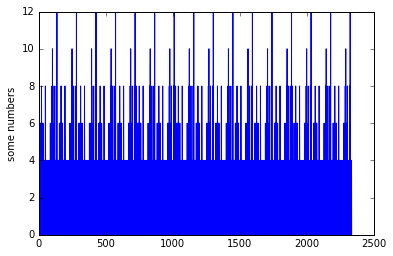

In [44]:
plt.plot(pt_complex.tss)
plt.ylabel('some numbers')
plt.show()

### Plot precision/recall for each iteration of probabilistic record linkage

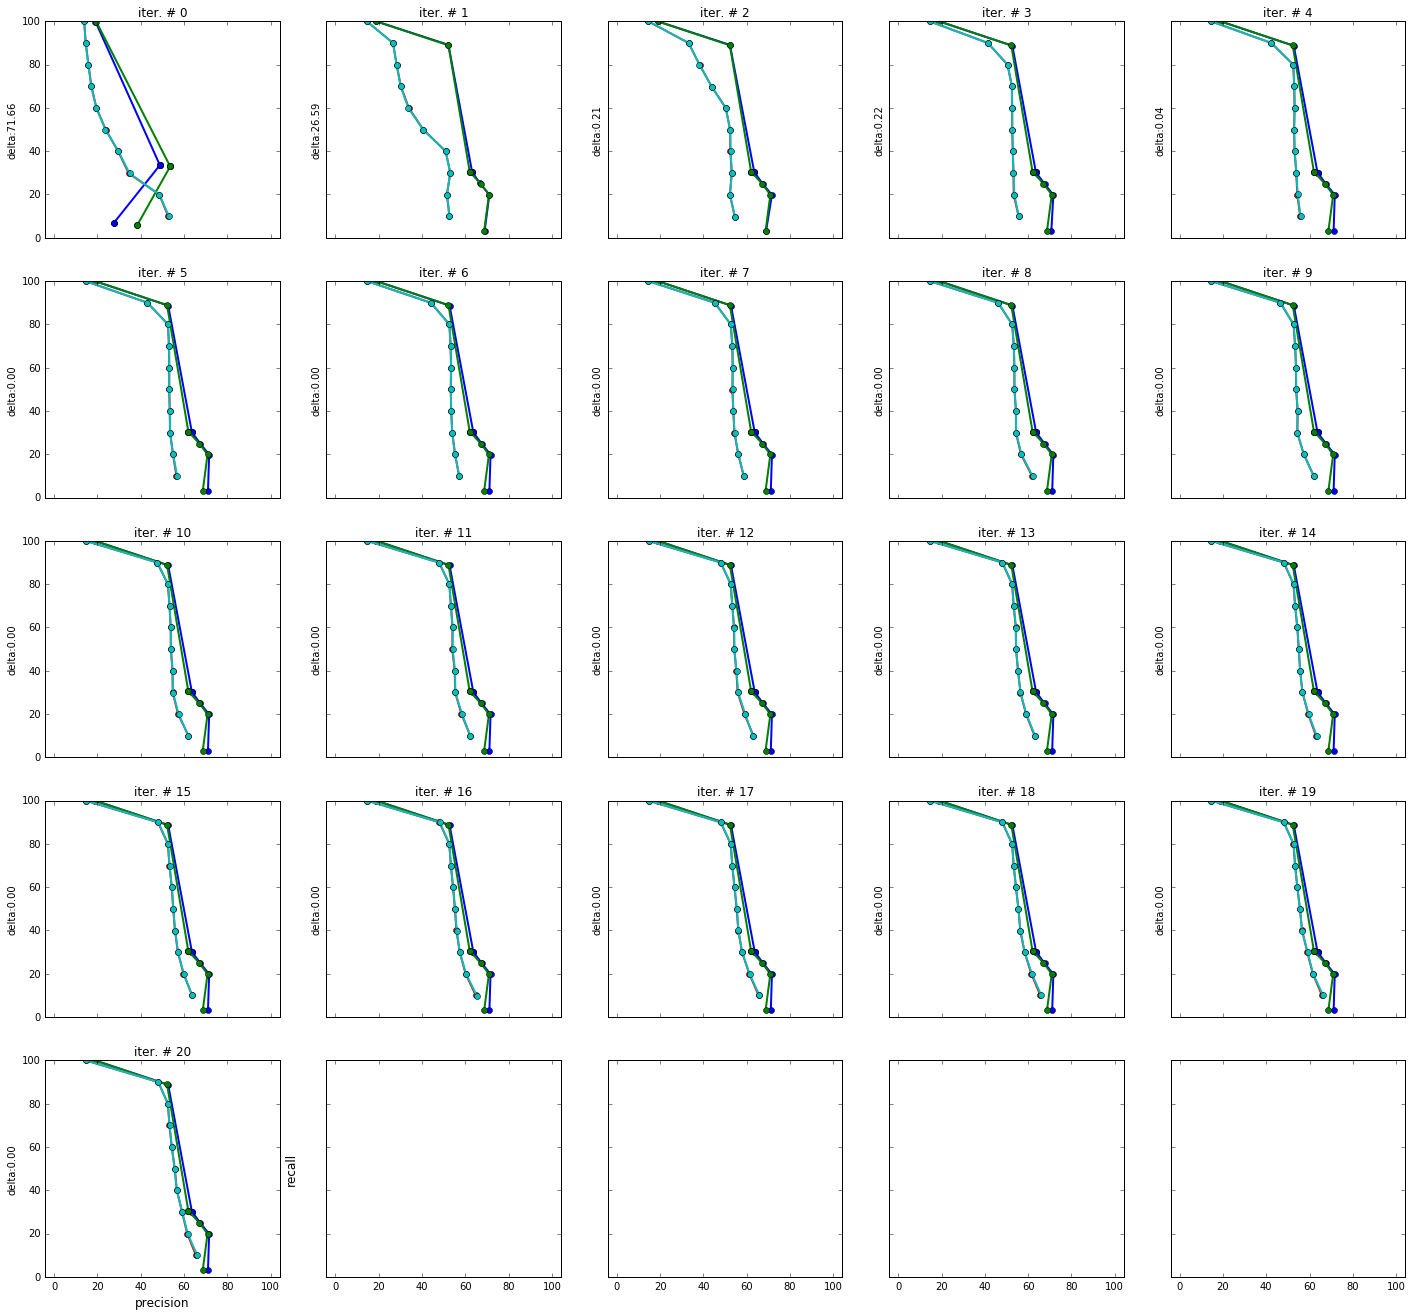

In [6]:
deltas = np.diff(pr_complex.iter_qual_list)

learner_list = [pr_complex,pr_simple,pt_complex,pt_simple]
plot_prec_list = [o.prec_list for o in learner_list]
plot_recall_list = [o.recall_list for o in learner_list]
color_list = ['b','g','r','c'][slice(len(learner_list))]

ncol = int(np.ceil(np.sqrt(len(plot_prec_list[0]))))
nrow = int(np.ceil(len(plot_recall_list[0])/float(ncol)))
fig, axs = plt.subplots(nrow, ncol, sharex='col', sharey='row')
for i, ax in enumerate(fig.axes[0:len(plot_prec_list[0])]):   
    plot_curves = lambda x,y,z: ax.plot(x[i], y[i], '-', linewidth=2, marker='o', color=z)
    map(plot_curves,plot_prec_list,plot_recall_list,color_list)
    
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])
    ax.set_title("iter. # {}".format(str(i)), fontsize=12)
    ax.set_ylabel("delta:{0:3.2f}".format(float(deltas[i])), fontsize=10)
    ax.set(aspect='equal')    
else:
    ax.set_xlabel('precision', fontsize=12)
    ax2 = ax.twinx()
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('recall', fontsize=12)
    
fig.set_size_inches(4.875*ncol,4.5*nrow)
plt.show()
fig.savefig('prec_recall.png')

In [11]:
# Show equivalence between row-iteration and matrix multiplication
inputs_list = bool_table[feature_vals]
predictions,score = pt_complex.query(inputs_list)
targets = np.array(bool_table['match'], ndmin=2)

inputs = np.array(inputs_list, ndmin=2)
inputs = np.concatenate((inputs,np.repeat(1, len(inputs[:,1]))[:, None]), axis=1) # Add bias input
weights = np.random.uniform(low=-0.01, high=0.01, size=len(inputs[1,:]))
    
output_errors = targets-predictions
print output_errors
#print inputs.shape,weights.shape,output_errors.shape

#print learning_rate * np.dot(output_errors, inputs)

for i,row in enumerate(inputs):
    foo = output_errors[:,i] * row
    weights += learning_rate * output_errors[:,i] * row
#print weights

[[ 0.  0.  0.  0. -1.  0.  0. -1.  0. -1. -1. -1. -1. -1. -1.  0.]]


In [11]:
cutoff = theta[-1]
winners = (big_bool['linkage_score']>cutoff)
print sum(winners&big_bool['real_match'])
print sum(winners&big_bool['pair_match']&big_bool['real_match'])
print sum(big_bool['pair_match']&big_bool['real_match'])

# Precision: the percent of pairs with a score above theta that are real matches
# USE ONLY NOMINATED PAIRS
# - numerator: number of NOMINATED pairs with a score above theta that are real matches
real_picks = sum(winners&big_bool['real_match']&big_bool['pair_match'])
# - denominater: number of NOMINATED pairs with a score above theta
picks = sum(winners&big_bool['pair_match'])
precision = (real_picks/float(picks)*100)

# Recall: the percent of known matched pairs that get a score above theta
# - numerator: number of NOMINATED pairs with a score above theta that are real matches
# - denominater: number of pairs that are real matches
real_matches = big_bool['real_match'].sum()
recall = (real_picks/float(real_matches)*100)

print precision,recall

37
32
484
84.2105263158 4.59110473458


In [ ]:

"""
[1,  '< 500g',          1,    1 ..  499, 1],
    [2,  '500 to 749g',     2,  500 ..  749, 1],
    [3,  '750 to 999g',     3,  750 ..  999, 1],
    [4,  '1,000 to 1,250g', 4, 1000 .. 1250, 2],
    [5,  '1,250 to 1,499g', 5, 1250 .. 1499, 2],
    [6,  '1,500 to 1,749g', 6, 1500 .. 1749, 3],
    [7,  '1,750 to 1,999g', 7, 1750 .. 1999, 4],
    [8,  '2,000 to 2,499g', 8, 2000 .. 2499, 5],
    [9,  '> 2,500g',        9, 2500 .. 9999, 6],
    # Overweight?!?
    [11, 'Unknown',         0, []],
"""


data = list(cross_table['birth_weight'])
        
bw_bins = np.concatenate(([1], np.arange(500, 2001, 250),[2500,9999]), axis=0)
print bw_bins

inds = np.digitize(data, bw_bins)

for n in range(len(data)):
    print(bw_bins[inds[n]-1], "<=", data[n], "<", bw_bins[inds[n]])


In [ ]:
data = cross_table['gestational_age_ob_estimate']/7

# '<24 weeks','24 weeks','25-26 weeks','27-28 weeks',...'35-36 weeks','37 or more weeks'
        
bins = np.concatenate(([0,24], np.arange(25, 36, 2),[99]), axis=0)
print bins

inds = np.digitize(data.tolist(), bins)

for n in range(len(data)):
    print(bins[inds[n]-1], "<=", data[n], "<", bins[inds[n]])


### Update 'births' table accordingly

In [ ]:
foo = fin_bool.loc[big_bool['pair_match']==1]
for index, row in foo.iterrows():     
    stmt1 = '''
        UPDATE births 
        SET newborn_id_2 = %d, newborn_linkage_score_2 = %s
        WHERE id = %d;
        ''' % (row['newb_id'], row['linkage_score'], row['bc_id'])
    exec_statement(stmt1)